In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np 
import pandas as pd
from scipy import stats
import itertools
import operator
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import optimizers, regularizers
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import *
from keras import backend as K
from keras.models import load_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold
import h5py
import pickle

sns.set(style='ticks', palette='muted', font_scale=1.5)

Using TensorFlow backend.


In [2]:
BI_CLASSES = [('downstairs', 'upstairs'), ('downstairs', 'walking'), ('jogging', 'upstairs'), ('upstairs', 'walking')]
N_CLASSES = 7
N_TIME_STEPS = 200
N_FEATURES = 3

N_EPOCHS = 170
BATCH_SIZE = 1024
LEARNING_RATE = 0.0001

In [3]:
def tf_swish(x):
    return x * tf.nn.sigmoid(x)

def ks_swish(x):
    return x * K.sigmoid(x)

def cnn_model():
    model = Sequential()
    model.add(Conv2D(128, (2, 2), input_shape=(N_TIME_STEPS, N_FEATURES, 1)))
    model.add(Activation(ks_swish))
    model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation(ks_swish))
    model.add(Dense(128))
    model.add(Activation(ks_swish))
    model.add(Dense(2, activation='softmax'))
    adam = optimizers.Adam(lr = LEARNING_RATE, decay=1e-6)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

def feature_normalize(dataset):
    mu = np.mean(dataset, axis = 0)
    sigma = np.std(dataset, axis = 0)
    return (dataset - mu) / sigma

def segment_signal(data, N_TIME_STEPS = 200, step = 20):
    segments = [] 
    labels = []
    for i in range(0, len(data) - N_TIME_STEPS, step):
        xs = data['x-axis'].values[i: i + N_TIME_STEPS]
        ys = data['y-axis'].values[i: i + N_TIME_STEPS]
        zs = data['z-axis'].values[i: i + N_TIME_STEPS]
        label = stats.mode(data['activity'][i: i + N_TIME_STEPS])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
    return segments, labels

def combinations(combination, features, labels):
    combinations_x = [0] * len(combination)
    combinations_y = [0] * len(combination)
    for i in chosen:
        temp_x = [] 
        temp_y = [] 
        for k in range(2):
            for j in range(len(labels)):
                if (combination[i][k] == labels[j]):
                    temp_x.append(features[j])
                    temp_y.append(labels[j])
        combinations_x[i] = np.asarray(temp_x, dtype=np.float32).reshape(len(temp_x), N_TIME_STEPS, N_FEATURES, 1)
        combinations_y[i] = np.asarray(pd.get_dummies(temp_y), dtype=np.float32)
    return combinations_x, combinations_y

def final_prediction(X_temp_test, predictions, threshold):
    cnn_predictions = np.copy(predictions)
    i = 0
    while i < len(predictions):
        sorted_index = np.argsort(cnn_predictions[i])[::-1]
        test_cnn = X_temp_test[i].reshape(1, N_TIME_STEPS, N_FEATURES, 1)
        k = 0
        j = 1
        while j < len(sorted_index):        
            if sorted_index[k] > sorted_index[j]:
                t = int(N_CLASSES * sorted_index[j] - sorted_index[j] * (sorted_index[j] + 1) / 2 + sorted_index[k] - sorted_index[j] - 1)     
            else:
                t = int(N_CLASSES * sorted_index[k] - sorted_index[k] * (sorted_index[k] + 1) / 2 + sorted_index[j] - sorted_index[k] - 1)
            if cnn_models[t] != None:
                if threshold > cnn_predictions[i][sorted_index[k]] / cnn_predictions[i][sorted_index[j]]:    
                    p = cnn_models[t].predict(test_cnn)
                    if np.argmax(p):
                        if sorted_index[k] < sorted_index[j]:
                            k = j
                    else:
                        if sorted_index[k] > sorted_index[j]:
                            k = j
                else:
                    break;
            j = j + 1     
        cnn_predictions[i] = 0
        cnn_predictions[i][sorted_index[k]] = 1
        i = i + 1
    return cnn_predictions

def threshold_vs_accuraccy(history):
    plt.rcdefaults()
    plt.plot(history['threshold'], history['accuracy'], 'r-')
    plt.plot(history['threshold'], history['f1score'], 'g-')
    plt.show()
    
def confusion_report(predictions, y_test):
    max_test = np.argmax(y_test, axis=1)
    max_predictions = np.argmax(predictions, axis=1)
    confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

    plt.figure(figsize=(16, 14))
    sns.heatmap(confusion_matrix, xticklabels=np.unique(df.activity), yticklabels=np.unique(df.activity), annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show();

In [4]:
columns = ['x-axis', 'y-axis', 'z-axis','activity']
df = pd.read_csv('data/SHOAIB_wrist.txt', header = None, names = columns)
df = df.dropna()

In [5]:
df.dtypes

x-axis      float64
y-axis      float64
z-axis      float64
activity     object
dtype: object

In [6]:
df['x-axis'] = feature_normalize(df['x-axis'])
df['y-axis'] = feature_normalize(df['y-axis'])
df['z-axis'] = feature_normalize(df['z-axis'])

In [7]:
segments, labels = segment_signal(df)

c:\users\kinai\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [8]:
reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)

In [9]:
combination = list(itertools.combinations(np.unique(labels, axis=0), 2))
n_combination = len(combination)
print("Combinations: ", n_combination)
print(combination)

Combinations:  21
[('biking', 'downstairs'), ('biking', 'jogging'), ('biking', 'sitting'), ('biking', 'standing'), ('biking', 'upstairs'), ('biking', 'walking'), ('downstairs', 'jogging'), ('downstairs', 'sitting'), ('downstairs', 'standing'), ('downstairs', 'upstairs'), ('downstairs', 'walking'), ('jogging', 'sitting'), ('jogging', 'standing'), ('jogging', 'upstairs'), ('jogging', 'walking'), ('sitting', 'standing'), ('sitting', 'upstairs'), ('sitting', 'walking'), ('standing', 'upstairs'), ('standing', 'walking'), ('upstairs', 'walking')]


In [10]:
chosen = []
for i in range(len(BI_CLASSES)):
    chosen.append(combination.index(BI_CLASSES[i]))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.3, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [12]:
X_c_train, y_c_train = combinations(combination, X_train, y_train)
X_c_validation, y_c_validation = combinations(combination, X_validation, y_validation)

In [13]:
y_train = np.asarray(pd.get_dummies(y_train), dtype = np.float32)
y_test = np.asarray(pd.get_dummies(y_test), dtype = np.float32)
y_validation = np.asarray(pd.get_dummies(y_validation), dtype = np.float32)

In [14]:
N_HIDDEN_UNITS = 128
keep_prob_ = tf.placeholder(tf.float32, name = 'keep')

In [15]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }

    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf_swish(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)
    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [16]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

L2_LOSS = 0.0015

l2 = L2_LOSS * \
        sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [18]:
history = dict(train_loss=[], train_acc=[], test_loss=[], test_acc=[])

sess = tf.InteractiveSession()  
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE), range(BATCH_SIZE, train_count + 1, BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end], Y: y_train[start:end]})

    train_predictions, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)
        
    if i != 1 and i % 10 != 0:
        continue

    print('epoch:', i, 'train accuracy:', acc_train, 'loss train:', loss_train, 'test accuracy:', acc_test, 'test loss:', loss_test)
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})
validation_predictions, validation_acc, validation_loss = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_validation, Y: y_validation})
print()
print('final results: accuracy:', acc_final, 'loss:', loss_final, 'validation accuracy:', validation_acc, 'validation loss:', validation_loss)

epoch: 1 train accuracy: 0.3591217 loss train: 3.043539 test accuracy: 0.35693872 test loss: 3.0510464
epoch: 10 train accuracy: 0.8150254 loss train: 2.1237364 test accuracy: 0.8145443 test loss: 2.1224868
epoch: 20 train accuracy: 0.8861602 loss train: 1.9189947 test accuracy: 0.8867365 test loss: 1.9250238
epoch: 30 train accuracy: 0.9470723 loss train: 1.7820052 test accuracy: 0.9472849 test loss: 1.7836318
epoch: 40 train accuracy: 0.96255744 loss train: 1.7228943 test accuracy: 0.9577644 test loss: 1.7349298
epoch: 50 train accuracy: 0.97060245 loss train: 1.6911968 test accuracy: 0.9666561 test loss: 1.7015302
epoch: 60 train accuracy: 0.9688483 loss train: 1.6687979 test accuracy: 0.9633746 test loss: 1.6856239
epoch: 70 train accuracy: 0.98040164 loss train: 1.6229731 test accuracy: 0.9769239 test loss: 1.6364135
epoch: 80 train accuracy: 0.9838495 loss train: 1.5952486 test accuracy: 0.97755903 test loss: 1.6139634
epoch: 90 train accuracy: 0.98717636 loss train: 1.5664254 te

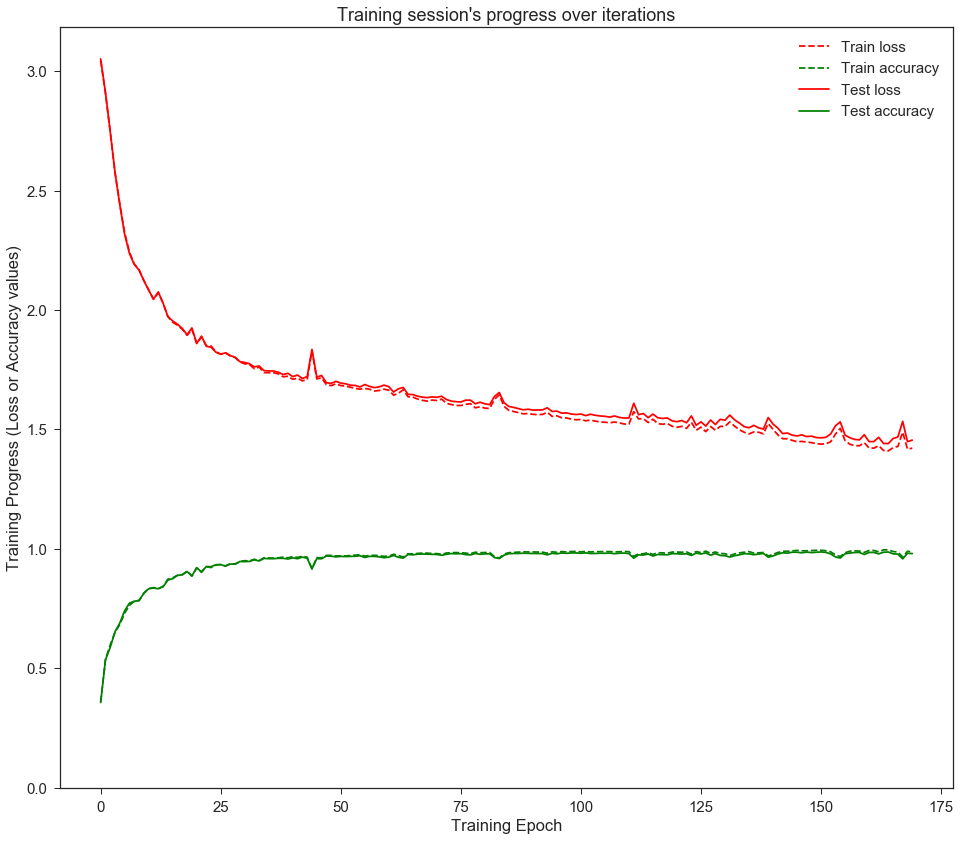

In [19]:
plt.figure(figsize=(16, 14))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

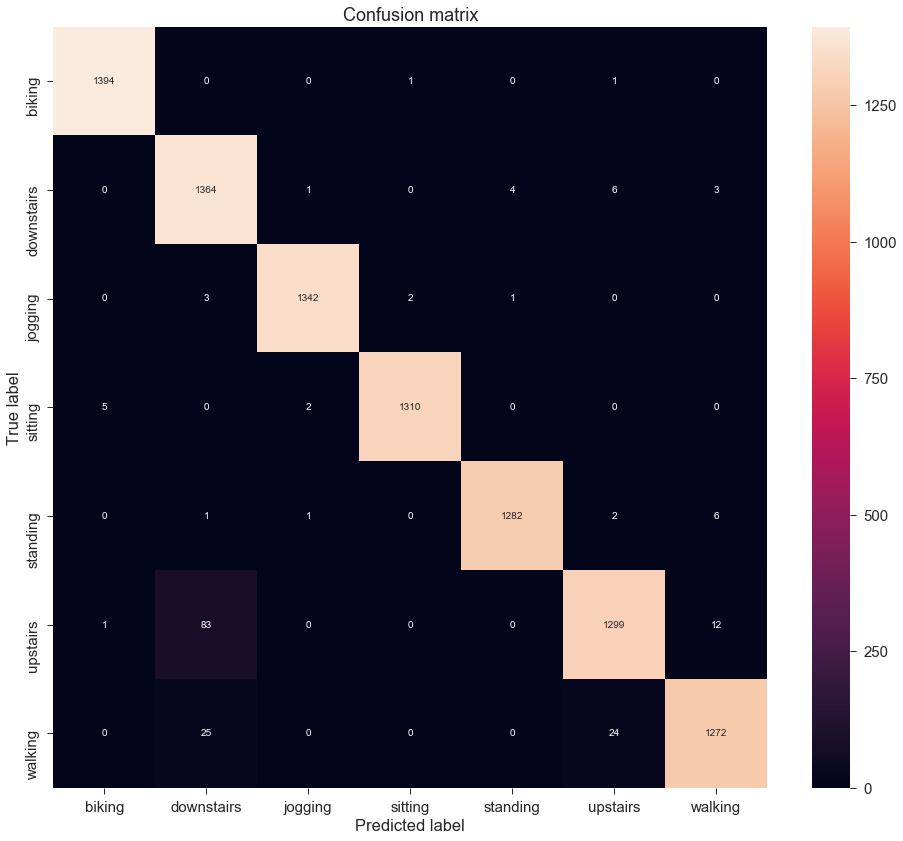

In [20]:
confusion_report(predictions, y_test)

In [21]:
batch_size = [4, 8, 16, 32]
#batch_size = [128]
param_grid = dict(batch_size = batch_size)
earlyStopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, mode = 'auto')
cnn_models = [None] * n_combination
for i in chosen:    
    model = KerasClassifier(build_fn = cnn_model)
    grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5)
    grid.fit(X_c_train[i], y_c_train[i], epochs = N_EPOCHS, callbacks = [earlyStopping], validation_data = (X_c_validation[i], y_c_validation[i]))
    print("Best: %f using %s" %(grid.best_score_, grid.best_params_))
    cnn_models[i] = grid.best_estimator_.model

Train on 3737 samples, validate on 1549 samples
Epoch 1/170
3737/3737 [==============================] - 39s 10ms/step - loss: 0.3036 - acc: 0.8807 - val_loss: 0.2612 - val_acc: 0.9019
Epoch 2/170
3737/3737 [==============================] - 30s 8ms/step - loss: 0.2120 - acc: 0.9176 - val_loss: 0.2214 - val_acc: 0.9167
Epoch 3/170
3737/3737 [==============================] - 31s 8ms/step - loss: 0.1805 - acc: 0.9336 - val_loss: 0.2141 - val_acc: 0.9251
Epoch 4/170
3737/3737 [==============================] - 31s 8ms/step - loss: 0.1626 - acc: 0.9414 - val_loss: 0.1940 - val_acc: 0.9329
Epoch 5/170
3737/3737 [==============================] - 33s 9ms/step - loss: 0.1377 - acc: 0.9545 - val_loss: 0.1964 - val_acc: 0.9264
Epoch 6/170
3737/3737 [==============================] - 32s 8ms/step - loss: 0.1175 - acc: 0.9612 - val_loss: 0.2304 - val_acc: 0.9206
Epoch 7/170
3737/3737 [==============================] - 32s 9ms/step - loss: 0.0961 - acc: 0.9663 - val_loss: 0.1430 - val_acc: 0.9529

3738/3738 [==============================] - 31s 8ms/step - loss: 0.1201 - acc: 0.9559 - val_loss: 0.3013 - val_acc: 0.8890
Epoch 7/170
3738/3738 [==============================] - 32s 8ms/step - loss: 0.0990 - acc: 0.9642 - val_loss: 0.1684 - val_acc: 0.9509
Epoch 8/170
3738/3738 [==============================] - 31s 8ms/step - loss: 0.0785 - acc: 0.9727 - val_loss: 0.1736 - val_acc: 0.9522
Epoch 9/170
3738/3738 [==============================] - 31s 8ms/step - loss: 0.0666 - acc: 0.9759 - val_loss: 0.2300 - val_acc: 0.9303
Epoch 10/170
3738/3738 [==============================] - 32s 8ms/step - loss: 0.0501 - acc: 0.9831 - val_loss: 0.1568 - val_acc: 0.9619
Epoch 11/170
3738/3738 [==============================] - 31s 8ms/step - loss: 0.0427 - acc: 0.9856 - val_loss: 0.1561 - val_acc: 0.9613
Epoch 12/170
3738/3738 [==============================] - 36s 10ms/step - loss: 0.0345 - acc: 0.9877 - val_loss: 0.1438 - val_acc: 0.9638
Epoch 13/170
3738/3738 [==============================] 

3737/3737 [==============================] - 16s 4ms/step - loss: 0.1182 - acc: 0.9569 - val_loss: 0.1684 - val_acc: 0.9432
Epoch 9/170
3737/3737 [==============================] - 16s 4ms/step - loss: 0.1019 - acc: 0.9652 - val_loss: 0.1564 - val_acc: 0.9490
Epoch 10/170
3737/3737 [==============================] - 16s 4ms/step - loss: 0.0810 - acc: 0.9724 - val_loss: 0.1522 - val_acc: 0.9484
Epoch 11/170
3737/3737 [==============================] - 17s 5ms/step - loss: 0.0742 - acc: 0.9727 - val_loss: 0.1513 - val_acc: 0.9548
Epoch 12/170
3737/3737 [==============================] - 17s 4ms/step - loss: 0.0581 - acc: 0.9799 - val_loss: 0.1332 - val_acc: 0.9574
Epoch 13/170
3737/3737 [==============================] - 18s 5ms/step - loss: 0.0512 - acc: 0.9807 - val_loss: 0.1500 - val_acc: 0.9567
Epoch 14/170
3737/3737 [==============================] - 18s 5ms/step - loss: 0.0386 - acc: 0.9874 - val_loss: 0.1282 - val_acc: 0.9651
Epoch 15/170
3737/3737 [==============================]

3738/3738 [==============================] - 17s 4ms/step - loss: 0.2076 - acc: 0.9248 - val_loss: 0.2832 - val_acc: 0.9019
Epoch 3/170
3738/3738 [==============================] - 16s 4ms/step - loss: 0.1838 - acc: 0.9312 - val_loss: 0.2600 - val_acc: 0.9116
Epoch 4/170
3738/3738 [==============================] - 16s 4ms/step - loss: 0.1689 - acc: 0.9363 - val_loss: 0.2407 - val_acc: 0.9238
Epoch 5/170
3738/3738 [==============================] - 16s 4ms/step - loss: 0.1533 - acc: 0.9409 - val_loss: 0.2310 - val_acc: 0.9316
Epoch 6/170
3738/3738 [==============================] - 17s 5ms/step - loss: 0.1433 - acc: 0.9470 - val_loss: 0.2202 - val_acc: 0.9264
Epoch 7/170
3738/3738 [==============================] - 16s 4ms/step - loss: 0.1247 - acc: 0.9529 - val_loss: 0.2018 - val_acc: 0.9380
Epoch 8/170
3738/3738 [==============================] - 16s 4ms/step - loss: 0.1139 - acc: 0.9599 - val_loss: 0.2007 - val_acc: 0.9380
Epoch 9/170
3738/3738 [==============================] - 16s

3737/3737 [==============================] - 10s 3ms/step - loss: 0.0287 - acc: 0.9888 - val_loss: 0.1429 - val_acc: 0.9619
Epoch 22/170
3737/3737 [==============================] - 10s 3ms/step - loss: 0.0231 - acc: 0.9925 - val_loss: 0.1385 - val_acc: 0.9632
Epoch 23/170
3737/3737 [==============================] - 10s 3ms/step - loss: 0.0211 - acc: 0.9930 - val_loss: 0.1562 - val_acc: 0.9626
Epoch 24/170
3737/3737 [==============================] - 10s 3ms/step - loss: 0.0237 - acc: 0.9896 - val_loss: 0.1387 - val_acc: 0.9638
Epoch 25/170
3737/3737 [==============================] - 10s 3ms/step - loss: 0.0137 - acc: 0.9963 - val_loss: 0.1518 - val_acc: 0.9703
Epoch 26/170
3737/3737 [==============================] - 10s 3ms/step - loss: 0.0131 - acc: 0.9957 - val_loss: 0.1402 - val_acc: 0.9664
Epoch 27/170
3737/3737 [==============================] - 2s 459us/step
Train on 3737 samples, validate on 1549 samples
Epoch 1/170
3737/3737 [==============================] - 14s 4ms/step -

3738/3738 [==============================] - 10s 3ms/step - loss: 0.0311 - acc: 0.9896 - val_loss: 0.1262 - val_acc: 0.9651
Epoch 23/170
3738/3738 [==============================] - 10s 3ms/step - loss: 0.0192 - acc: 0.9944 - val_loss: 0.1466 - val_acc: 0.9632
Epoch 24/170
3738/3738 [==============================] - 10s 3ms/step - loss: 0.0158 - acc: 0.9946 - val_loss: 0.1626 - val_acc: 0.9567
Epoch 25/170
3738/3738 [==============================] - 10s 3ms/step - loss: 0.0139 - acc: 0.9963 - val_loss: 0.1486 - val_acc: 0.9671
Epoch 26/170
3738/3738 [==============================] - 10s 3ms/step - loss: 0.0125 - acc: 0.9965 - val_loss: 0.1522 - val_acc: 0.9677
Epoch 27/170
3738/3738 [==============================] - 2s 452us/step
Train on 3738 samples, validate on 1549 samples
Epoch 1/170
3738/3738 [==============================] - 14s 4ms/step - loss: 0.3466 - acc: 0.8625 - val_loss: 0.3069 - val_acc: 0.8890
Epoch 2/170
3738/3738 [==============================] - 10s 3ms/step - 

3737/3737 [==============================] - 7s 2ms/step - loss: 0.2126 - acc: 0.9240 - val_loss: 0.2534 - val_acc: 0.9103
Epoch 4/170
3737/3737 [==============================] - 7s 2ms/step - loss: 0.1912 - acc: 0.9331 - val_loss: 0.2410 - val_acc: 0.9180
Epoch 5/170
3737/3737 [==============================] - 7s 2ms/step - loss: 0.1815 - acc: 0.9368 - val_loss: 0.2274 - val_acc: 0.9206
Epoch 6/170
3737/3737 [==============================] - 7s 2ms/step - loss: 0.1641 - acc: 0.9449 - val_loss: 0.2134 - val_acc: 0.9296
Epoch 7/170
3737/3737 [==============================] - 7s 2ms/step - loss: 0.1549 - acc: 0.9454 - val_loss: 0.2168 - val_acc: 0.9270
Epoch 8/170
3737/3737 [==============================] - 7s 2ms/step - loss: 0.1385 - acc: 0.9518 - val_loss: 0.2028 - val_acc: 0.9354
Epoch 9/170
3737/3737 [==============================] - 7s 2ms/step - loss: 0.1300 - acc: 0.9516 - val_loss: 0.2029 - val_acc: 0.9374
Epoch 10/170
3737/3737 [==============================] - 7s 2ms/st

3737/3737 [==============================] - 7s 2ms/step - loss: 0.0229 - acc: 0.9922 - val_loss: 0.1382 - val_acc: 0.9645
Epoch 33/170
3737/3737 [==============================] - 1s 383us/step
Train on 3738 samples, validate on 1549 samples
Epoch 1/170
3738/3738 [==============================] - 11s 3ms/step - loss: 0.4203 - acc: 0.8189 - val_loss: 0.2755 - val_acc: 0.9064
Epoch 2/170
3738/3738 [==============================] - 7s 2ms/step - loss: 0.2301 - acc: 0.9171 - val_loss: 0.2661 - val_acc: 0.9083
Epoch 3/170
3738/3738 [==============================] - 7s 2ms/step - loss: 0.2083 - acc: 0.9230 - val_loss: 0.2539 - val_acc: 0.9135
Epoch 4/170
3738/3738 [==============================] - 7s 2ms/step - loss: 0.1947 - acc: 0.9294 - val_loss: 0.3074 - val_acc: 0.8941
Epoch 5/170
3738/3738 [==============================] - 7s 2ms/step - loss: 0.1868 - acc: 0.9307 - val_loss: 0.2492 - val_acc: 0.9180
Epoch 6/170
3738/3738 [==============================] - 7s 2ms/step - loss: 0.16

3738/3738 [==============================] - 7s 2ms/step - loss: 0.0442 - acc: 0.9845 - val_loss: 0.1647 - val_acc: 0.9509
Epoch 25/170
3738/3738 [==============================] - 7s 2ms/step - loss: 0.0387 - acc: 0.9856 - val_loss: 0.1716 - val_acc: 0.9567
Epoch 26/170
3738/3738 [==============================] - 7s 2ms/step - loss: 0.0365 - acc: 0.9869 - val_loss: 0.2053 - val_acc: 0.9490
Epoch 27/170
3738/3738 [==============================] - 7s 2ms/step - loss: 0.0295 - acc: 0.9906 - val_loss: 0.1612 - val_acc: 0.9645
Epoch 28/170
3738/3738 [==============================] - 7s 2ms/step - loss: 0.0271 - acc: 0.9933 - val_loss: 0.1573 - val_acc: 0.9645
Epoch 29/170
3738/3738 [==============================] - 7s 2ms/step - loss: 0.0208 - acc: 0.9944 - val_loss: 0.1716 - val_acc: 0.9613
Epoch 30/170
3738/3738 [==============================] - 7s 2ms/step - loss: 0.0191 - acc: 0.9941 - val_loss: 0.1959 - val_acc: 0.9548
Epoch 31/170
3738/3738 [==============================] - 7s 

4672/4672 [==============================] - 20s 4ms/step - loss: 0.0727 - acc: 0.9754 - val_loss: 0.1426 - val_acc: 0.9587
Epoch 11/170
4672/4672 [==============================] - 20s 4ms/step - loss: 0.0602 - acc: 0.9780 - val_loss: 0.1221 - val_acc: 0.9645
Epoch 12/170
4672/4672 [==============================] - 20s 4ms/step - loss: 0.0527 - acc: 0.9822 - val_loss: 0.1260 - val_acc: 0.9606
Epoch 13/170
4672/4672 [==============================] - 21s 4ms/step - loss: 0.0411 - acc: 0.9857 - val_loss: 0.1284 - val_acc: 0.9638
Epoch 14/170
4672/4672 [==============================] - 20s 4ms/step - loss: 0.0385 - acc: 0.9874 - val_loss: 0.1128 - val_acc: 0.9626
Epoch 15/170
4672/4672 [==============================] - 20s 4ms/step - loss: 0.0274 - acc: 0.9917 - val_loss: 0.1011 - val_acc: 0.9722
Epoch 16/170
4672/4672 [==============================] - 20s 4ms/step - loss: 0.0268 - acc: 0.9897 - val_loss: 0.1086 - val_acc: 0.9716
Epoch 17/170
4672/4672 [==============================

3811/3811 [==============================] - 36s 9ms/step - loss: 0.2571 - acc: 0.8880 - val_loss: 0.1877 - val_acc: 0.9194
Epoch 2/170
3811/3811 [==============================] - 32s 8ms/step - loss: 0.1753 - acc: 0.9278 - val_loss: 0.1883 - val_acc: 0.9247
Epoch 3/170
3811/3811 [==============================] - 32s 8ms/step - loss: 0.1464 - acc: 0.9386 - val_loss: 0.1557 - val_acc: 0.9371
Epoch 4/170
3811/3811 [==============================] - 31s 8ms/step - loss: 0.1150 - acc: 0.9538 - val_loss: 0.1300 - val_acc: 0.9463
Epoch 5/170
3811/3811 [==============================] - 32s 8ms/step - loss: 0.0766 - acc: 0.9706 - val_loss: 0.0977 - val_acc: 0.9673
Epoch 6/170
3811/3811 [==============================] - 32s 8ms/step - loss: 0.0433 - acc: 0.9871 - val_loss: 0.0622 - val_acc: 0.9790
Epoch 7/170
3811/3811 [==============================] - 32s 8ms/step - loss: 0.0296 - acc: 0.9913 - val_loss: 0.0759 - val_acc: 0.9784
Epoch 8/170
3811/3811 [==============================] - 32s

3811/3811 [==============================] - 17s 4ms/step - loss: 0.1066 - acc: 0.9654 - val_loss: 0.1578 - val_acc: 0.9411
Epoch 7/170
3811/3811 [==============================] - 17s 4ms/step - loss: 0.0889 - acc: 0.9672 - val_loss: 0.1522 - val_acc: 0.9417
Epoch 8/170
3811/3811 [==============================] - 17s 4ms/step - loss: 0.0725 - acc: 0.9756 - val_loss: 0.1412 - val_acc: 0.9502
Epoch 9/170
3811/3811 [==============================] - 17s 4ms/step - loss: 0.0657 - acc: 0.9785 - val_loss: 0.1237 - val_acc: 0.9574
Epoch 10/170
3811/3811 [==============================] - 17s 4ms/step - loss: 0.0456 - acc: 0.9850 - val_loss: 0.0902 - val_acc: 0.9725
Epoch 11/170
3811/3811 [==============================] - 18s 5ms/step - loss: 0.0323 - acc: 0.9900 - val_loss: 0.1190 - val_acc: 0.9620
Epoch 12/170
3811/3811 [==============================] - 17s 5ms/step - loss: 0.0249 - acc: 0.9919 - val_loss: 0.0709 - val_acc: 0.9790
Epoch 13/170
3811/3811 [==============================] -

3812/3812 [==============================] - 17s 4ms/step - loss: 0.0884 - acc: 0.9698 - val_loss: 0.1071 - val_acc: 0.9601
Epoch 8/170
3812/3812 [==============================] - 17s 4ms/step - loss: 0.0635 - acc: 0.9774 - val_loss: 0.0893 - val_acc: 0.9725
Epoch 9/170
3812/3812 [==============================] - 17s 4ms/step - loss: 0.0467 - acc: 0.9829 - val_loss: 0.0703 - val_acc: 0.9777
Epoch 10/170
3812/3812 [==============================] - 17s 4ms/step - loss: 0.0344 - acc: 0.9887 - val_loss: 0.0609 - val_acc: 0.9810
Epoch 11/170
3812/3812 [==============================] - 17s 4ms/step - loss: 0.0207 - acc: 0.9937 - val_loss: 0.0708 - val_acc: 0.9777
Epoch 12/170
3812/3812 [==============================] - 17s 4ms/step - loss: 0.0165 - acc: 0.9953 - val_loss: 0.0529 - val_acc: 0.9856
Epoch 13/170
3812/3812 [==============================] - 17s 4ms/step - loss: 0.0147 - acc: 0.9958 - val_loss: 0.0507 - val_acc: 0.9882
Epoch 14/170
3812/3812 [==============================] 

3811/3811 [==============================] - 10s 3ms/step - loss: 0.0784 - acc: 0.9759 - val_loss: 0.1254 - val_acc: 0.9581
Epoch 9/170
3811/3811 [==============================] - 11s 3ms/step - loss: 0.0633 - acc: 0.9803 - val_loss: 0.1010 - val_acc: 0.9699
Epoch 10/170
3811/3811 [==============================] - 11s 3ms/step - loss: 0.0496 - acc: 0.9869 - val_loss: 0.0913 - val_acc: 0.9725
Epoch 11/170
3811/3811 [==============================] - 10s 3ms/step - loss: 0.0368 - acc: 0.9900 - val_loss: 0.0788 - val_acc: 0.9764
Epoch 12/170
3811/3811 [==============================] - 11s 3ms/step - loss: 0.0286 - acc: 0.9927 - val_loss: 0.0826 - val_acc: 0.9784
Epoch 13/170
3811/3811 [==============================] - 11s 3ms/step - loss: 0.0224 - acc: 0.9934 - val_loss: 0.0729 - val_acc: 0.9790
Epoch 14/170
3811/3811 [==============================] - 11s 3ms/step - loss: 0.0159 - acc: 0.9955 - val_loss: 0.0620 - val_acc: 0.9836
Epoch 15/170
3811/3811 [==============================]

3811/3811 [==============================] - 7s 2ms/step - loss: 0.1789 - acc: 0.9362 - val_loss: 0.1772 - val_acc: 0.9325
Epoch 3/170
3811/3811 [==============================] - 7s 2ms/step - loss: 0.1617 - acc: 0.9433 - val_loss: 0.1868 - val_acc: 0.9293
Epoch 4/170
3811/3811 [==============================] - 7s 2ms/step - loss: 0.1558 - acc: 0.9415 - val_loss: 0.1726 - val_acc: 0.9267
Epoch 5/170
3811/3811 [==============================] - 7s 2ms/step - loss: 0.1641 - acc: 0.9389 - val_loss: 0.1685 - val_acc: 0.9339
Epoch 6/170
3811/3811 [==============================] - 7s 2ms/step - loss: 0.1379 - acc: 0.9528 - val_loss: 0.1808 - val_acc: 0.9306
Epoch 7/170
3811/3811 [==============================] - 7s 2ms/step - loss: 0.1274 - acc: 0.9559 - val_loss: 0.1583 - val_acc: 0.9371
Epoch 8/170
3811/3811 [==============================] - 7s 2ms/step - loss: 0.1244 - acc: 0.9606 - val_loss: 0.1802 - val_acc: 0.9352
Epoch 9/170
3811/3811 [==============================] - 7s 2ms/ste

3811/3811 [==============================] - 7s 2ms/step - loss: 0.0065 - acc: 0.9987 - val_loss: 0.0768 - val_acc: 0.9817
Epoch 29/170
3811/3811 [==============================] - 7s 2ms/step - loss: 0.0054 - acc: 0.9990 - val_loss: 0.0780 - val_acc: 0.9804
Epoch 30/170
3811/3811 [==============================] - 7s 2ms/step - loss: 0.0036 - acc: 0.9997 - val_loss: 0.0963 - val_acc: 0.9771
Epoch 31/170
3811/3811 [==============================] - 2s 419us/step
Train on 3811 samples, validate on 1527 samples
Epoch 1/170
3811/3811 [==============================] - 13s 3ms/step - loss: 0.3727 - acc: 0.8586 - val_loss: 0.1977 - val_acc: 0.9221
Epoch 2/170
3811/3811 [==============================] - 7s 2ms/step - loss: 0.1739 - acc: 0.9307 - val_loss: 0.1906 - val_acc: 0.9293
Epoch 3/170
3811/3811 [==============================] - 7s 2ms/step - loss: 0.1670 - acc: 0.9328 - val_loss: 0.1891 - val_acc: 0.9188
Epoch 4/170
3811/3811 [==============================] - 7s 2ms/step - loss: 0.

3811/3811 [==============================] - 8s 2ms/step - loss: 0.0197 - acc: 0.9942 - val_loss: 0.0930 - val_acc: 0.9758
Epoch 29/170
3811/3811 [==============================] - 8s 2ms/step - loss: 0.0049 - acc: 0.9992 - val_loss: 0.0694 - val_acc: 0.9869
Epoch 30/170
3811/3811 [==============================] - 2s 426us/step
Train on 3812 samples, validate on 1527 samples
Epoch 1/170
3812/3812 [==============================] - 13s 3ms/step - loss: 0.3835 - acc: 0.8360 - val_loss: 0.2324 - val_acc: 0.8847
Epoch 2/170
3812/3812 [==============================] - 7s 2ms/step - loss: 0.1834 - acc: 0.9229 - val_loss: 0.1835 - val_acc: 0.9273
Epoch 3/170
3812/3812 [==============================] - 7s 2ms/step - loss: 0.1645 - acc: 0.9318 - val_loss: 0.1886 - val_acc: 0.9260
Epoch 4/170
3812/3812 [==============================] - 8s 2ms/step - loss: 0.1634 - acc: 0.9273 - val_loss: 0.1778 - val_acc: 0.9293
Epoch 5/170
3812/3812 [==============================] - 7s 2ms/step - loss: 0.1

3718/3718 [==============================] - 32s 9ms/step - loss: 2.2358e-05 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 0.9988
Epoch 7/170
3718/3718 [==============================] - 5s 1ms/step
Train on 3718 samples, validate on 1609 samples
Epoch 1/170
3718/3718 [==============================] - 38s 10ms/step - loss: 0.0186 - acc: 0.9962 - val_loss: 0.0104 - val_acc: 0.9975
Epoch 2/170
3718/3718 [==============================] - 32s 9ms/step - loss: 0.0051 - acc: 0.9984 - val_loss: 0.0075 - val_acc: 0.9975
Epoch 3/170
3718/3718 [==============================] - 32s 9ms/step - loss: 0.0020 - acc: 0.9997 - val_loss: 0.0070 - val_acc: 0.9981
Epoch 4/170
3718/3718 [==============================] - 32s 9ms/step - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0069 - val_acc: 0.9988
Epoch 5/170
3718/3718 [==============================] - 32s 9ms/step - loss: 2.0992e-04 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 0.9988
Epoch 6/170
3718/3718 [==============================] - 32s 9ms/step 

3718/3718 [==============================] - 17s 5ms/step - loss: 9.3375e-04 - acc: 0.9997 - val_loss: 0.0080 - val_acc: 0.9981
Epoch 6/170
3718/3718 [==============================] - 17s 5ms/step - loss: 4.2315e-04 - acc: 0.9997 - val_loss: 0.0078 - val_acc: 0.9981
Epoch 7/170
3718/3718 [==============================] - 17s 5ms/step - loss: 1.2917e-04 - acc: 1.0000 - val_loss: 0.0087 - val_acc: 0.9981
Epoch 8/170
3718/3718 [==============================] - 3s 681us/step
Train on 3719 samples, validate on 1609 samples
Epoch 1/170
3719/3719 [==============================] - 25s 7ms/step - loss: 0.0225 - acc: 0.9965 - val_loss: 0.0081 - val_acc: 0.9975
Epoch 2/170
3719/3719 [==============================] - 17s 5ms/step - loss: 0.0031 - acc: 0.9989 - val_loss: 0.0109 - val_acc: 0.9975
Epoch 3/170
3719/3719 [==============================] - 17s 5ms/step - loss: 0.0018 - acc: 0.9997 - val_loss: 0.0167 - val_acc: 0.9969
Epoch 4/170
3719/3719 [==============================] - 18s 5ms/

3718/3718 [==============================] - 11s 3ms/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.0057 - val_acc: 0.9981
Epoch 7/170
3718/3718 [==============================] - 10s 3ms/step - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0059 - val_acc: 0.9981
Epoch 8/170
3718/3718 [==============================] - 10s 3ms/step - loss: 8.3253e-04 - acc: 0.9997 - val_loss: 0.0061 - val_acc: 0.9981
Epoch 9/170
3718/3718 [==============================] - 10s 3ms/step - loss: 5.1952e-04 - acc: 0.9997 - val_loss: 0.0056 - val_acc: 0.9981
Epoch 10/170
3718/3718 [==============================] - 11s 3ms/step - loss: 2.8742e-04 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 0.9975
Epoch 11/170
3718/3718 [==============================] - 11s 3ms/step - loss: 1.5097e-04 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 0.9975
Epoch 12/170
3718/3718 [==============================] - 11s 3ms/step - loss: 8.1328e-05 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.9975
Epoch 13/170
3718/3718 [=============

Epoch 6/170
3718/3718 [==============================] - 7s 2ms/step - loss: 8.6756e-04 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9981
Epoch 7/170
3718/3718 [==============================] - 7s 2ms/step - loss: 5.1867e-04 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9981
Epoch 8/170
3718/3718 [==============================] - 2s 445us/step
Train on 3718 samples, validate on 1609 samples
Epoch 1/170
3718/3718 [==============================] - 14s 4ms/step - loss: 0.0683 - acc: 0.9941 - val_loss: 0.0089 - val_acc: 0.9975
Epoch 2/170
3718/3718 [==============================] - 7s 2ms/step - loss: 0.0069 - acc: 0.9981 - val_loss: 0.0076 - val_acc: 0.9981
Epoch 3/170
3718/3718 [==============================] - 7s 2ms/step - loss: 0.0045 - acc: 0.9984 - val_loss: 0.0067 - val_acc: 0.9975
Epoch 4/170
3718/3718 [==============================] - 7s 2ms/step - loss: 0.0034 - acc: 0.9989 - val_loss: 0.0065 - val_acc: 0.9981
Epoch 5/170
3718/3718 [==============================] - 7s 2m

3755/3755 [==============================] - 33s 9ms/step - loss: 0.1949 - acc: 0.9310 - val_loss: 0.1511 - val_acc: 0.9470
Epoch 4/170
3755/3755 [==============================] - 33s 9ms/step - loss: 0.1410 - acc: 0.9545 - val_loss: 0.2045 - val_acc: 0.9202
Epoch 5/170
3755/3755 [==============================] - 33s 9ms/step - loss: 0.1122 - acc: 0.9609 - val_loss: 0.1101 - val_acc: 0.9706
Epoch 6/170
3755/3755 [==============================] - 33s 9ms/step - loss: 0.1000 - acc: 0.9632 - val_loss: 0.1016 - val_acc: 0.9725
Epoch 7/170
3755/3755 [==============================] - 37s 10ms/step - loss: 0.0747 - acc: 0.9758 - val_loss: 0.1244 - val_acc: 0.9604
Epoch 8/170
3755/3755 [==============================] - 38s 10ms/step - loss: 0.0750 - acc: 0.9739 - val_loss: 0.1124 - val_acc: 0.9623
Epoch 9/170
3755/3755 [==============================] - 36s 10ms/step - loss: 0.0536 - acc: 0.9803 - val_loss: 0.1191 - val_acc: 0.9662
Epoch 10/170
3755/3755 [==============================] -

Epoch 15/170
3755/3755 [==============================] - 38s 10ms/step - loss: 0.0155 - acc: 0.9952 - val_loss: 0.1006 - val_acc: 0.9713
Epoch 16/170
3755/3755 [==============================] - 37s 10ms/step - loss: 0.0187 - acc: 0.9949 - val_loss: 0.0910 - val_acc: 0.9796
Epoch 17/170
3755/3755 [==============================] - 6s 2ms/step
Train on 3756 samples, validate on 1566 samples
Epoch 1/170
3756/3756 [==============================] - 45s 12ms/step - loss: 0.6215 - acc: 0.6603 - val_loss: 0.4293 - val_acc: 0.8276
Epoch 2/170
3756/3756 [==============================] - 37s 10ms/step - loss: 0.3065 - acc: 0.8727 - val_loss: 0.2109 - val_acc: 0.9285
Epoch 3/170
3756/3756 [==============================] - 37s 10ms/step - loss: 0.1863 - acc: 0.9305 - val_loss: 0.1486 - val_acc: 0.9489
Epoch 4/170
3756/3756 [==============================] - 35s 9ms/step - loss: 0.1392 - acc: 0.9526 - val_loss: 0.1506 - val_acc: 0.9534
Epoch 5/170
3756/3756 [==============================] - 39

3755/3755 [==============================] - 3s 828us/step
Train on 3755 samples, validate on 1566 samples
Epoch 1/170
3755/3755 [==============================] - 27s 7ms/step - loss: 0.6559 - acc: 0.5989 - val_loss: 0.5203 - val_acc: 0.7791
Epoch 2/170
3755/3755 [==============================] - 19s 5ms/step - loss: 0.3467 - acc: 0.8575 - val_loss: 0.2521 - val_acc: 0.8978
Epoch 3/170
3755/3755 [==============================] - 19s 5ms/step - loss: 0.1969 - acc: 0.9286 - val_loss: 0.1707 - val_acc: 0.9330
Epoch 4/170
3755/3755 [==============================] - 18s 5ms/step - loss: 0.1483 - acc: 0.9462 - val_loss: 0.1510 - val_acc: 0.9432
Epoch 5/170
3755/3755 [==============================] - 19s 5ms/step - loss: 0.1193 - acc: 0.9601 - val_loss: 0.1428 - val_acc: 0.9540
Epoch 6/170
3755/3755 [==============================] - 19s 5ms/step - loss: 0.1103 - acc: 0.9566 - val_loss: 0.1215 - val_acc: 0.9636
Epoch 7/170
3755/3755 [==============================] - 19s 5ms/step - loss:

3755/3755 [==============================] - 11s 3ms/step - loss: 0.1529 - acc: 0.9467 - val_loss: 0.1778 - val_acc: 0.9413
Epoch 7/170
3755/3755 [==============================] - 11s 3ms/step - loss: 0.1244 - acc: 0.9585 - val_loss: 0.1639 - val_acc: 0.9425
Epoch 8/170
3755/3755 [==============================] - 11s 3ms/step - loss: 0.1120 - acc: 0.9627 - val_loss: 0.1359 - val_acc: 0.9585
Epoch 9/170
3755/3755 [==============================] - 11s 3ms/step - loss: 0.1093 - acc: 0.9640 - val_loss: 0.1359 - val_acc: 0.9540
Epoch 10/170
3755/3755 [==============================] - 11s 3ms/step - loss: 0.0953 - acc: 0.9710 - val_loss: 0.2298 - val_acc: 0.9061
Epoch 11/170
3755/3755 [==============================] - 11s 3ms/step - loss: 0.0871 - acc: 0.9699 - val_loss: 0.1179 - val_acc: 0.9636
Epoch 12/170
3755/3755 [==============================] - 11s 3ms/step - loss: 0.0822 - acc: 0.9734 - val_loss: 0.1132 - val_acc: 0.9719
Epoch 13/170
3755/3755 [==============================] -

3755/3755 [==============================] - 12s 3ms/step - loss: 0.0455 - acc: 0.9872 - val_loss: 0.1034 - val_acc: 0.9706
Epoch 16/170
3755/3755 [==============================] - 12s 3ms/step - loss: 0.0377 - acc: 0.9901 - val_loss: 0.1011 - val_acc: 0.9738
Epoch 17/170
3755/3755 [==============================] - 12s 3ms/step - loss: 0.0361 - acc: 0.9877 - val_loss: 0.1037 - val_acc: 0.9706
Epoch 18/170
3755/3755 [==============================] - 12s 3ms/step - loss: 0.0321 - acc: 0.9901 - val_loss: 0.1427 - val_acc: 0.9534
Epoch 19/170
3755/3755 [==============================] - 11s 3ms/step - loss: 0.0404 - acc: 0.9870 - val_loss: 0.0954 - val_acc: 0.9764
Epoch 20/170
3755/3755 [==============================] - 11s 3ms/step - loss: 0.0275 - acc: 0.9925 - val_loss: 0.1043 - val_acc: 0.9757
Epoch 21/170
3755/3755 [==============================] - 11s 3ms/step - loss: 0.0206 - acc: 0.9949 - val_loss: 0.0985 - val_acc: 0.9764
Epoch 22/170
3755/3755 [==============================

3756/3756 [==============================] - 11s 3ms/step - loss: 0.0247 - acc: 0.9931 - val_loss: 0.1084 - val_acc: 0.9796
Epoch 25/170
3756/3756 [==============================] - 11s 3ms/step - loss: 0.0272 - acc: 0.9912 - val_loss: 0.1066 - val_acc: 0.9738
Epoch 26/170
3756/3756 [==============================] - 11s 3ms/step - loss: 0.0223 - acc: 0.9936 - val_loss: 0.1137 - val_acc: 0.9713
Epoch 27/170
3756/3756 [==============================] - 2s 573us/step
Train on 3755 samples, validate on 1566 samples
Epoch 1/170
3755/3755 [==============================] - 16s 4ms/step - loss: 0.6461 - acc: 0.6394 - val_loss: 0.7097 - val_acc: 0.4968
Epoch 2/170
3755/3755 [==============================] - 8s 2ms/step - loss: 0.6127 - acc: 0.6519 - val_loss: 0.6242 - val_acc: 0.5664
Epoch 3/170
3755/3755 [==============================] - 8s 2ms/step - loss: 0.4921 - acc: 0.7731 - val_loss: 0.4698 - val_acc: 0.7778
Epoch 4/170
3755/3755 [==============================] - 8s 2ms/step - loss:

3755/3755 [==============================] - 17s 4ms/step - loss: 0.6868 - acc: 0.5510 - val_loss: 0.6786 - val_acc: 0.5006
Epoch 2/170
3755/3755 [==============================] - 8s 2ms/step - loss: 0.6504 - acc: 0.6383 - val_loss: 0.6023 - val_acc: 0.6814
Epoch 3/170
3755/3755 [==============================] - 8s 2ms/step - loss: 0.4962 - acc: 0.8037 - val_loss: 0.3923 - val_acc: 0.8602
Epoch 4/170
3755/3755 [==============================] - 8s 2ms/step - loss: 0.3134 - acc: 0.8855 - val_loss: 0.2706 - val_acc: 0.9049
Epoch 5/170
3755/3755 [==============================] - 8s 2ms/step - loss: 0.2319 - acc: 0.9177 - val_loss: 0.2149 - val_acc: 0.9176
Epoch 6/170
3755/3755 [==============================] - 8s 2ms/step - loss: 0.1902 - acc: 0.9249 - val_loss: 0.1871 - val_acc: 0.9285
Epoch 7/170
3755/3755 [==============================] - 8s 2ms/step - loss: 0.1746 - acc: 0.9329 - val_loss: 0.2168 - val_acc: 0.9093
Epoch 8/170
3755/3755 [==============================] - 8s 2ms/st

3756/3756 [==============================] - 8s 2ms/step - loss: 0.4701 - acc: 0.7875 - val_loss: 0.3871 - val_acc: 0.8301
Epoch 4/170
3756/3756 [==============================] - 8s 2ms/step - loss: 0.3013 - acc: 0.8871 - val_loss: 0.2960 - val_acc: 0.8921
Epoch 5/170
3756/3756 [==============================] - 8s 2ms/step - loss: 0.2241 - acc: 0.9199 - val_loss: 0.2253 - val_acc: 0.9227
Epoch 6/170
3756/3756 [==============================] - 8s 2ms/step - loss: 0.1779 - acc: 0.9348 - val_loss: 0.1730 - val_acc: 0.9349
Epoch 7/170
3756/3756 [==============================] - 8s 2ms/step - loss: 0.1549 - acc: 0.9483 - val_loss: 0.1850 - val_acc: 0.9381
Epoch 8/170
3756/3756 [==============================] - 8s 2ms/step - loss: 0.1600 - acc: 0.9438 - val_loss: 0.1451 - val_acc: 0.9476
Epoch 9/170
3756/3756 [==============================] - 8s 2ms/step - loss: 0.1355 - acc: 0.9491 - val_loss: 0.1387 - val_acc: 0.9534
Epoch 10/170
3756/3756 [==============================] - 8s 2ms/st

In [22]:
validation_history = dict(accuracy=[], f1score=[], threshold=[])
threshold = 0
while (threshold < 10):    
    c_predictions = final_prediction(X_validation, validation_predictions, threshold)
    accuracy = accuracy_score(np.argmax(y_validation, 1), np.argmax(c_predictions, 1)) 
    f1score = f1_score(np.argmax(y_validation, 1), np.argmax(c_predictions, 1), average='weighted')
    print("accuracy:", accuracy, "f1_score:", f1score,"threshold:", threshold)
    threshold += 0.01
    validation_history['accuracy'].append(accuracy)
    validation_history['f1score'].append(f1score)
    validation_history['threshold'].append(threshold)

accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.01
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.02
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.03
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.04
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.05
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.060000000000000005
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.07
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.08
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.09
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.09999999999999999
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.10999999999999999
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 

accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.9600000000000006
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.9700000000000006
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.9800000000000006
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 0.9900000000000007
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 1.0000000000000007
accuracy: 0.9787697332607512 f1_score: 0.9788199109938377 threshold: 1.0100000000000007
accuracy: 0.9787697332607512 f1_score: 0.9788242687377416 threshold: 1.0200000000000007
accuracy: 0.9787697332607512 f1_score: 0.9788242687377416 threshold: 1.0300000000000007
accuracy: 0.9791326438033024 f1_score: 0.9791794425355531 threshold: 1.0400000000000007
accuracy: 0.9791326438033024 f1_score: 0.9791794425355531 threshold: 1.0500000000000007
accuracy: 0.9791326438033024 f1_score: 0.9791794425355531 threshold: 1.0600000000000007
accuracy: 0.9791326438033024 f1_

accuracy: 0.9809471965160588 f1_score: 0.9809815918531971 threshold: 1.9000000000000015
accuracy: 0.9809471965160588 f1_score: 0.9809815918531971 threshold: 1.9100000000000015
accuracy: 0.9809471965160588 f1_score: 0.9809815918531971 threshold: 1.9200000000000015
accuracy: 0.9809471965160588 f1_score: 0.9809815918531971 threshold: 1.9300000000000015
accuracy: 0.9809471965160588 f1_score: 0.9809815918531971 threshold: 1.9400000000000015
accuracy: 0.9809471965160588 f1_score: 0.9809815918531971 threshold: 1.9500000000000015
accuracy: 0.9809471965160588 f1_score: 0.9809815918531971 threshold: 1.9600000000000015
accuracy: 0.9809471965160588 f1_score: 0.9809815918531971 threshold: 1.9700000000000015
accuracy: 0.9809471965160588 f1_score: 0.9809815918531971 threshold: 1.9800000000000015
accuracy: 0.9809471965160588 f1_score: 0.9809815918531971 threshold: 1.9900000000000015
accuracy: 0.9809471965160588 f1_score: 0.9809815918531971 threshold: 2.0000000000000013
accuracy: 0.9809471965160588 f1_

accuracy: 0.981854472872437 f1_score: 0.9818914591231415 threshold: 2.8399999999999834
accuracy: 0.981854472872437 f1_score: 0.9818914591231415 threshold: 2.849999999999983
accuracy: 0.981854472872437 f1_score: 0.9818914591231415 threshold: 2.859999999999983
accuracy: 0.981854472872437 f1_score: 0.9818914591231415 threshold: 2.869999999999983
accuracy: 0.981854472872437 f1_score: 0.9818914591231415 threshold: 2.8799999999999826
accuracy: 0.981854472872437 f1_score: 0.9818914591231415 threshold: 2.8899999999999824
accuracy: 0.9820359281437125 f1_score: 0.9820723127407799 threshold: 2.899999999999982
accuracy: 0.9820359281437125 f1_score: 0.9820723127407799 threshold: 2.909999999999982
accuracy: 0.9820359281437125 f1_score: 0.9820723127407799 threshold: 2.9199999999999817
accuracy: 0.9820359281437125 f1_score: 0.9820723127407799 threshold: 2.9299999999999815
accuracy: 0.9820359281437125 f1_score: 0.9820723127407799 threshold: 2.9399999999999813
accuracy: 0.9820359281437125 f1_score: 0.98

accuracy: 0.9827617492288151 f1_score: 0.9827941323701428 threshold: 3.7799999999999634
accuracy: 0.9827617492288151 f1_score: 0.9827941323701428 threshold: 3.789999999999963
accuracy: 0.9827617492288151 f1_score: 0.9827941323701428 threshold: 3.799999999999963
accuracy: 0.9827617492288151 f1_score: 0.9827941323701428 threshold: 3.8099999999999627
accuracy: 0.9827617492288151 f1_score: 0.9827941323701428 threshold: 3.8199999999999625
accuracy: 0.9827617492288151 f1_score: 0.9827941323701428 threshold: 3.8299999999999623
accuracy: 0.9827617492288151 f1_score: 0.9827941323701428 threshold: 3.839999999999962
accuracy: 0.9825802939575394 f1_score: 0.982616018339088 threshold: 3.849999999999962
accuracy: 0.9825802939575394 f1_score: 0.982616018339088 threshold: 3.8599999999999617
accuracy: 0.9825802939575394 f1_score: 0.982616018339088 threshold: 3.8699999999999615
accuracy: 0.9825802939575394 f1_score: 0.982616018339088 threshold: 3.8799999999999613
accuracy: 0.9825802939575394 f1_score: 0

accuracy: 0.9831246597713663 f1_score: 0.9831557385637625 threshold: 4.729999999999944
accuracy: 0.9831246597713663 f1_score: 0.9831557385637625 threshold: 4.739999999999943
accuracy: 0.9831246597713663 f1_score: 0.9831557385637625 threshold: 4.749999999999943
accuracy: 0.9831246597713663 f1_score: 0.9831557385637625 threshold: 4.759999999999943
accuracy: 0.9831246597713663 f1_score: 0.9831557385637625 threshold: 4.769999999999943
accuracy: 0.9831246597713663 f1_score: 0.9831557385637625 threshold: 4.7799999999999425
accuracy: 0.9831246597713663 f1_score: 0.9831557385637625 threshold: 4.789999999999942
accuracy: 0.9831246597713663 f1_score: 0.9831557385637625 threshold: 4.799999999999942
accuracy: 0.9831246597713663 f1_score: 0.9831557385637625 threshold: 4.809999999999942
accuracy: 0.9831246597713663 f1_score: 0.9831557385637625 threshold: 4.819999999999942
accuracy: 0.9831246597713663 f1_score: 0.9831557385637625 threshold: 4.8299999999999415
accuracy: 0.9831246597713663 f1_score: 0.

accuracy: 0.9831246597713663 f1_score: 0.9831580282385367 threshold: 5.679999999999923
accuracy: 0.9831246597713663 f1_score: 0.9831580282385367 threshold: 5.689999999999923
accuracy: 0.9831246597713663 f1_score: 0.9831580282385367 threshold: 5.699999999999923
accuracy: 0.9831246597713663 f1_score: 0.9831580282385367 threshold: 5.709999999999923
accuracy: 0.9831246597713663 f1_score: 0.9831580282385367 threshold: 5.7199999999999225
accuracy: 0.9831246597713663 f1_score: 0.9831580282385367 threshold: 5.729999999999922
accuracy: 0.9831246597713663 f1_score: 0.9831580282385367 threshold: 5.739999999999922
accuracy: 0.9831246597713663 f1_score: 0.9831580282385367 threshold: 5.749999999999922
accuracy: 0.9831246597713663 f1_score: 0.9831580282385367 threshold: 5.759999999999922
accuracy: 0.9831246597713663 f1_score: 0.9831580282385367 threshold: 5.769999999999921
accuracy: 0.9831246597713663 f1_score: 0.9831580282385367 threshold: 5.779999999999921
accuracy: 0.9831246597713663 f1_score: 0.9

accuracy: 0.9834875703139176 f1_score: 0.9835269301296552 threshold: 6.629999999999903
accuracy: 0.9834875703139176 f1_score: 0.9835269301296552 threshold: 6.639999999999903
accuracy: 0.9834875703139176 f1_score: 0.9835269301296552 threshold: 6.649999999999903
accuracy: 0.9834875703139176 f1_score: 0.9835269301296552 threshold: 6.659999999999902
accuracy: 0.9834875703139176 f1_score: 0.9835269301296552 threshold: 6.669999999999902
accuracy: 0.9834875703139176 f1_score: 0.9835269301296552 threshold: 6.679999999999902
accuracy: 0.9834875703139176 f1_score: 0.9835269301296552 threshold: 6.689999999999902
accuracy: 0.9834875703139176 f1_score: 0.9835269301296552 threshold: 6.699999999999902
accuracy: 0.9834875703139176 f1_score: 0.9835269301296552 threshold: 6.709999999999901
accuracy: 0.9834875703139176 f1_score: 0.9835269301296552 threshold: 6.719999999999901
accuracy: 0.9834875703139176 f1_score: 0.9835269301296552 threshold: 6.729999999999901
accuracy: 0.9834875703139176 f1_score: 0.98

accuracy: 0.9838504808564689 f1_score: 0.983892409603532 threshold: 7.579999999999883
accuracy: 0.9838504808564689 f1_score: 0.983892409603532 threshold: 7.589999999999883
accuracy: 0.9838504808564689 f1_score: 0.983892409603532 threshold: 7.599999999999882
accuracy: 0.9838504808564689 f1_score: 0.983892409603532 threshold: 7.609999999999882
accuracy: 0.9838504808564689 f1_score: 0.983892409603532 threshold: 7.619999999999882
accuracy: 0.9838504808564689 f1_score: 0.983892409603532 threshold: 7.629999999999882
accuracy: 0.9838504808564689 f1_score: 0.983892409603532 threshold: 7.6399999999998816
accuracy: 0.9838504808564689 f1_score: 0.983892409603532 threshold: 7.649999999999881
accuracy: 0.9838504808564689 f1_score: 0.983892409603532 threshold: 7.659999999999881
accuracy: 0.9838504808564689 f1_score: 0.983892409603532 threshold: 7.669999999999881
accuracy: 0.9838504808564689 f1_score: 0.983892409603532 threshold: 7.679999999999881
accuracy: 0.9838504808564689 f1_score: 0.983892409603

accuracy: 0.9836690255851932 f1_score: 0.983713751637023 threshold: 8.539999999999862
accuracy: 0.9836690255851932 f1_score: 0.983713751637023 threshold: 8.549999999999862
accuracy: 0.9836690255851932 f1_score: 0.983713751637023 threshold: 8.559999999999862
accuracy: 0.9836690255851932 f1_score: 0.983713751637023 threshold: 8.569999999999862
accuracy: 0.9836690255851932 f1_score: 0.983713751637023 threshold: 8.579999999999862
accuracy: 0.9836690255851932 f1_score: 0.983713751637023 threshold: 8.589999999999861
accuracy: 0.9836690255851932 f1_score: 0.983713751637023 threshold: 8.599999999999861
accuracy: 0.9836690255851932 f1_score: 0.983713751637023 threshold: 8.60999999999986
accuracy: 0.9836690255851932 f1_score: 0.983713751637023 threshold: 8.61999999999986
accuracy: 0.9836690255851932 f1_score: 0.983713751637023 threshold: 8.62999999999986
accuracy: 0.9836690255851932 f1_score: 0.983713751637023 threshold: 8.63999999999986
accuracy: 0.9836690255851932 f1_score: 0.983713751637023 t

accuracy: 0.9834875703139176 f1_score: 0.9835340095728721 threshold: 9.499999999999842
accuracy: 0.9834875703139176 f1_score: 0.9835340095728721 threshold: 9.509999999999842
accuracy: 0.9834875703139176 f1_score: 0.9835340095728721 threshold: 9.519999999999841
accuracy: 0.9834875703139176 f1_score: 0.9835340095728721 threshold: 9.529999999999841
accuracy: 0.9834875703139176 f1_score: 0.9835340095728721 threshold: 9.539999999999841
accuracy: 0.9834875703139176 f1_score: 0.9835340095728721 threshold: 9.54999999999984
accuracy: 0.9834875703139176 f1_score: 0.9835340095728721 threshold: 9.55999999999984
accuracy: 0.9834875703139176 f1_score: 0.9835340095728721 threshold: 9.56999999999984
accuracy: 0.9834875703139176 f1_score: 0.9835340095728721 threshold: 9.57999999999984
accuracy: 0.9834875703139176 f1_score: 0.9835340095728721 threshold: 9.58999999999984
accuracy: 0.9836690255851932 f1_score: 0.9837143289656295 threshold: 9.59999999999984
accuracy: 0.9836690255851932 f1_score: 0.98371432

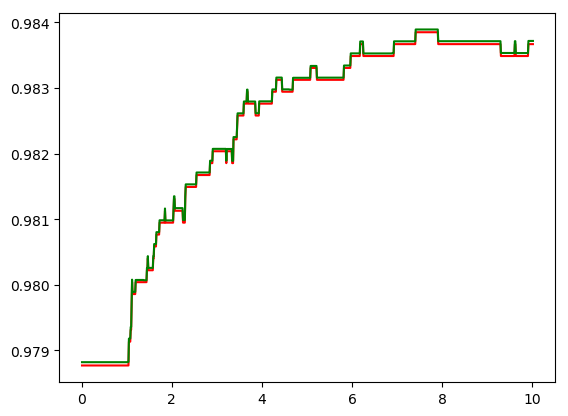

In [23]:
threshold_vs_accuraccy(validation_history)

In [24]:
threshold = validation_history['threshold'][validation_history['accuracy'].index(max(validation_history['accuracy']))]
cnn_predictions = final_prediction(X_test, predictions, threshold)
accuracy = accuracy_score(np.argmax(y_test, 1), np.argmax(cnn_predictions, 1))
f1score = f1_score(np.argmax(y_test, 1), np.argmax(cnn_predictions, 1), average='weighted')
print("final accuracy:", accuracy, "f1_score:", f1score,"threshold:", threshold)

final accuracy: 0.9849687731554991 f1_score: 0.984982446968162 threshold: 7.4099999999998865


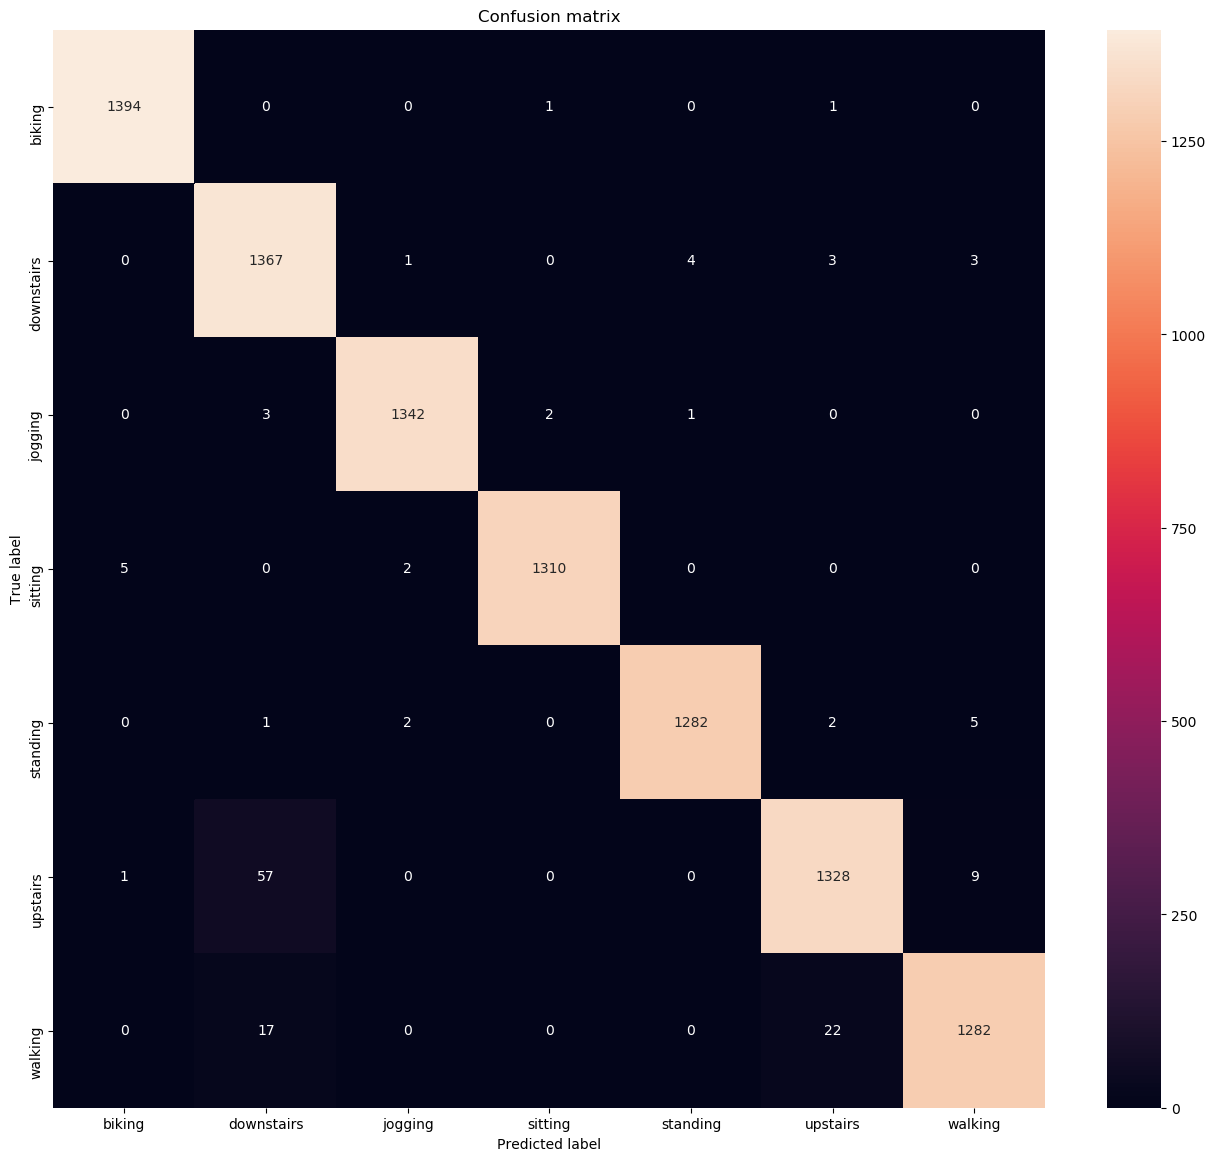

In [25]:
confusion_report(cnn_predictions, y_test)

In [26]:
print(classification_report(np.argmax(y_test, 1), np.argmax(cnn_predictions, 1)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1396
          1       0.95      0.99      0.97      1378
          2       1.00      1.00      1.00      1348
          3       1.00      0.99      1.00      1317
          4       1.00      0.99      0.99      1292
          5       0.98      0.95      0.97      1395
          6       0.99      0.97      0.98      1321

avg / total       0.99      0.98      0.98      9447



In [27]:
train_history = dict(accuracy=[], f1score=[], threshold=[])
threshold = 0
while (threshold < 3):    
    cnn_predictions = final_prediction(X_train, train_predictions, threshold)
    accuracy = accuracy_score(np.argmax(y_train, 1), np.argmax(cnn_predictions, 1)) 
    f1score = f1_score(np.argmax(y_train, 1), np.argmax(cnn_predictions, 1), average='weighted')
    print("accuracy:", accuracy, "f1_score:", f1score,"threshold:", threshold)
    threshold += 0.01
    train_history['accuracy'].append(accuracy)
    train_history['f1score'].append(f1score)
    train_history['threshold'].append(threshold)

accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.01
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.02
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.03
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.04
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.05
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.060000000000000005
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.07
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.08
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.09
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.09999999999999999
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.10999999999999999
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.11999999999

accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.9600000000000006
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.9700000000000006
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.9800000000000006
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 0.9900000000000007
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 1.0000000000000007
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 1.0100000000000007
accuracy: 0.9869949189450762 f1_score: 0.987030901307773 threshold: 1.0200000000000007
accuracy: 0.9870554076941689 f1_score: 0.9870905301382707 threshold: 1.0300000000000007
accuracy: 0.9871158964432616 f1_score: 0.987150636164011 threshold: 1.0400000000000007
accuracy: 0.9872368739414469 f1_score: 0.9872703903400731 threshold: 1.0500000000000007
accuracy: 0.9873578514396323 f1_score: 0.9873906139276859 threshold: 1.0600000000000007
accuracy: 0.9873578514396323 f1_score: 0

accuracy: 0.9914710863779337 f1_score: 0.9914867675707201 threshold: 1.9000000000000015
accuracy: 0.9915315751270264 f1_score: 0.9915475587919218 threshold: 1.9100000000000015
accuracy: 0.9915315751270264 f1_score: 0.9915475587919218 threshold: 1.9200000000000015
accuracy: 0.9915315751270264 f1_score: 0.9915475587919218 threshold: 1.9300000000000015
accuracy: 0.9915315751270264 f1_score: 0.9915475587919218 threshold: 1.9400000000000015
accuracy: 0.9915315751270264 f1_score: 0.9915475587919218 threshold: 1.9500000000000015
accuracy: 0.9915920638761191 f1_score: 0.9916083502021587 threshold: 1.9600000000000015
accuracy: 0.9916525526252117 f1_score: 0.9916685691442411 threshold: 1.9700000000000015
accuracy: 0.9916525526252117 f1_score: 0.9916685691442411 threshold: 1.9800000000000015
accuracy: 0.9916525526252117 f1_score: 0.9916685691442411 threshold: 1.9900000000000015
accuracy: 0.9916525526252117 f1_score: 0.9916685691442411 threshold: 2.0000000000000013
accuracy: 0.9917130413743044 f1_

accuracy: 0.9929833051052505 f1_score: 0.9929976968242434 threshold: 2.8399999999999834
accuracy: 0.9929833051052505 f1_score: 0.9929976968242434 threshold: 2.849999999999983
accuracy: 0.993043793854343 f1_score: 0.9930578972244001 threshold: 2.859999999999983
accuracy: 0.993043793854343 f1_score: 0.9930578972244001 threshold: 2.869999999999983
accuracy: 0.993043793854343 f1_score: 0.9930578972244001 threshold: 2.8799999999999826
accuracy: 0.993043793854343 f1_score: 0.9930578972244001 threshold: 2.8899999999999824
accuracy: 0.993043793854343 f1_score: 0.9930578972244001 threshold: 2.899999999999982
accuracy: 0.993043793854343 f1_score: 0.9930578972244001 threshold: 2.909999999999982
accuracy: 0.993043793854343 f1_score: 0.9930578972244001 threshold: 2.9199999999999817
accuracy: 0.993043793854343 f1_score: 0.9930578972244001 threshold: 2.9299999999999815
accuracy: 0.993043793854343 f1_score: 0.9930578972244001 threshold: 2.9399999999999813
accuracy: 0.993043793854343 f1_score: 0.993057

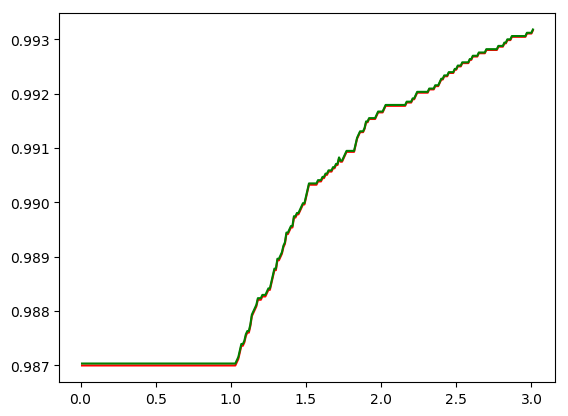

In [28]:
threshold_vs_accuraccy(train_history)

In [29]:
test_history = dict(accuracy=[], f1score=[], threshold=[])
threshold = 0
while (threshold < 10):    
    cnn_predictions = final_prediction(X_test, predictions, threshold)
    accuracy = accuracy_score(np.argmax(y_test, 1), np.argmax(cnn_predictions, 1)) 
    f1score = f1_score(np.argmax(y_test, 1), np.argmax(cnn_predictions, 1), average='weighted')
    print("accuracy:", accuracy, "f1_score:", f1score,"threshold:", threshold)
    threshold += 0.01
    test_history['accuracy'].append(accuracy)
    test_history['f1score'].append(f1score)
    test_history['threshold'].append(threshold)

accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.01
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.02
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.03
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.04
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.05
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.060000000000000005
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.07
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.08
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.09
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.09999999999999999
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.10999999999999999
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 

accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.9500000000000006
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.9600000000000006
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.9700000000000006
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.9800000000000006
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 0.9900000000000007
accuracy: 0.9805229173282524 f1_score: 0.9805523596551696 threshold: 1.0000000000000007
accuracy: 0.9806287710384249 f1_score: 0.9806577880414526 threshold: 1.0100000000000007
accuracy: 0.9807346247485974 f1_score: 0.9807633501197365 threshold: 1.0200000000000007
accuracy: 0.9807346247485974 f1_score: 0.9807633501197365 threshold: 1.0300000000000007
accuracy: 0.9806287710384249 f1_score: 0.9806577880414526 threshold: 1.0400000000000007
accuracy: 0.9807346247485974 f1_score: 0.9807665994547748 threshold: 1.0500000000000007
accuracy: 0.9807346247485974 f1_

accuracy: 0.982216576691013 f1_score: 0.982230026529517 threshold: 1.8900000000000015
accuracy: 0.982216576691013 f1_score: 0.982230026529517 threshold: 1.9000000000000015
accuracy: 0.982216576691013 f1_score: 0.982230026529517 threshold: 1.9100000000000015
accuracy: 0.9821107229808405 f1_score: 0.9821246077323472 threshold: 1.9200000000000015
accuracy: 0.9821107229808405 f1_score: 0.9821246077323472 threshold: 1.9300000000000015
accuracy: 0.9821107229808405 f1_score: 0.9821246077323472 threshold: 1.9400000000000015
accuracy: 0.982216576691013 f1_score: 0.9822295282738431 threshold: 1.9500000000000015
accuracy: 0.982216576691013 f1_score: 0.9822295282738431 threshold: 1.9600000000000015
accuracy: 0.982216576691013 f1_score: 0.9822295282738431 threshold: 1.9700000000000015
accuracy: 0.9823224304011856 f1_score: 0.9823352308210087 threshold: 1.9800000000000015
accuracy: 0.9823224304011856 f1_score: 0.9823352308210087 threshold: 1.9900000000000015
accuracy: 0.9823224304011856 f1_score: 0.

accuracy: 0.9834868212130835 f1_score: 0.9835042924335897 threshold: 2.8399999999999834
accuracy: 0.9834868212130835 f1_score: 0.9835042924335897 threshold: 2.849999999999983
accuracy: 0.9834868212130835 f1_score: 0.9835042924335897 threshold: 2.859999999999983
accuracy: 0.9834868212130835 f1_score: 0.9835042924335897 threshold: 2.869999999999983
accuracy: 0.9834868212130835 f1_score: 0.9835042924335897 threshold: 2.8799999999999826
accuracy: 0.9835926749232561 f1_score: 0.9836123689162285 threshold: 2.8899999999999824
accuracy: 0.9835926749232561 f1_score: 0.9836123689162285 threshold: 2.899999999999982
accuracy: 0.9835926749232561 f1_score: 0.9836123689162285 threshold: 2.909999999999982
accuracy: 0.9839102360537737 f1_score: 0.9839289551126817 threshold: 2.9199999999999817
accuracy: 0.9839102360537737 f1_score: 0.9839289551126817 threshold: 2.9299999999999815
accuracy: 0.9840160897639463 f1_score: 0.9840344730820112 threshold: 2.9399999999999813
accuracy: 0.9840160897639463 f1_score

accuracy: 0.9845453583148089 f1_score: 0.9845637332357562 threshold: 3.7799999999999634
accuracy: 0.9845453583148089 f1_score: 0.9845637332357562 threshold: 3.789999999999963
accuracy: 0.9845453583148089 f1_score: 0.9845637332357562 threshold: 3.799999999999963
accuracy: 0.9845453583148089 f1_score: 0.9845637332357562 threshold: 3.8099999999999627
accuracy: 0.9845453583148089 f1_score: 0.9845637332357562 threshold: 3.8199999999999625
accuracy: 0.9845453583148089 f1_score: 0.9845637332357562 threshold: 3.8299999999999623
accuracy: 0.9845453583148089 f1_score: 0.9845637332357562 threshold: 3.839999999999962
accuracy: 0.9845453583148089 f1_score: 0.9845637332357562 threshold: 3.849999999999962
accuracy: 0.9845453583148089 f1_score: 0.9845637332357562 threshold: 3.8599999999999617
accuracy: 0.9845453583148089 f1_score: 0.9845637332357562 threshold: 3.8699999999999615
accuracy: 0.9845453583148089 f1_score: 0.9845637332357562 threshold: 3.8799999999999613
accuracy: 0.9845453583148089 f1_scor

accuracy: 0.9845453583148089 f1_score: 0.9845618853709707 threshold: 4.729999999999944
accuracy: 0.9845453583148089 f1_score: 0.9845618853709707 threshold: 4.739999999999943
accuracy: 0.9845453583148089 f1_score: 0.9845618853709707 threshold: 4.749999999999943
accuracy: 0.9845453583148089 f1_score: 0.9845618853709707 threshold: 4.759999999999943
accuracy: 0.9845453583148089 f1_score: 0.9845618853709707 threshold: 4.769999999999943
accuracy: 0.9845453583148089 f1_score: 0.9845618853709707 threshold: 4.7799999999999425
accuracy: 0.9845453583148089 f1_score: 0.9845618853709707 threshold: 4.789999999999942
accuracy: 0.9845453583148089 f1_score: 0.9845618853709707 threshold: 4.799999999999942
accuracy: 0.9845453583148089 f1_score: 0.9845618853709707 threshold: 4.809999999999942
accuracy: 0.9845453583148089 f1_score: 0.9845618853709707 threshold: 4.819999999999942
accuracy: 0.9845453583148089 f1_score: 0.9845618853709707 threshold: 4.8299999999999415
accuracy: 0.9845453583148089 f1_score: 0.

accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 5.679999999999923
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 5.689999999999923
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 5.699999999999923
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 5.709999999999923
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 5.7199999999999225
accuracy: 0.9850746268656716 f1_score: 0.9850884614267351 threshold: 5.729999999999922
accuracy: 0.9850746268656716 f1_score: 0.9850884614267351 threshold: 5.739999999999922
accuracy: 0.9850746268656716 f1_score: 0.9850884614267351 threshold: 5.749999999999922
accuracy: 0.9850746268656716 f1_score: 0.9850884614267351 threshold: 5.759999999999922
accuracy: 0.9850746268656716 f1_score: 0.9850884614267351 threshold: 5.769999999999921
accuracy: 0.9850746268656716 f1_score: 0.9850884614267351 threshold: 5.779999999999921
accuracy: 0.9850746268656716 f1_score: 0.985088

accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 6.629999999999903
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 6.639999999999903
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 6.649999999999903
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 6.659999999999902
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 6.669999999999902
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 6.679999999999902
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 6.689999999999902
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 6.699999999999902
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 6.709999999999901
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 6.719999999999901
accuracy: 0.9849687731554991 f1_score: 0.984983868268796 threshold: 6.729999999999901
accuracy: 0.9849687731554991 f1_score: 0.9849838682687

accuracy: 0.9849687731554991 f1_score: 0.984982446968162 threshold: 7.589999999999883
accuracy: 0.9849687731554991 f1_score: 0.984982446968162 threshold: 7.599999999999882
accuracy: 0.9849687731554991 f1_score: 0.984982446968162 threshold: 7.609999999999882
accuracy: 0.9849687731554991 f1_score: 0.984982446968162 threshold: 7.619999999999882
accuracy: 0.9849687731554991 f1_score: 0.984982446968162 threshold: 7.629999999999882
accuracy: 0.9849687731554991 f1_score: 0.984982446968162 threshold: 7.6399999999998816
accuracy: 0.9849687731554991 f1_score: 0.984982446968162 threshold: 7.649999999999881
accuracy: 0.9849687731554991 f1_score: 0.984982446968162 threshold: 7.659999999999881
accuracy: 0.9849687731554991 f1_score: 0.984982446968162 threshold: 7.669999999999881
accuracy: 0.9849687731554991 f1_score: 0.984982446968162 threshold: 7.679999999999881
accuracy: 0.9849687731554991 f1_score: 0.984982446968162 threshold: 7.6899999999998805
accuracy: 0.9849687731554991 f1_score: 0.98498244696

accuracy: 0.9854980417063618 f1_score: 0.9855100960187776 threshold: 8.539999999999862
accuracy: 0.9854980417063618 f1_score: 0.9855100960187776 threshold: 8.549999999999862
accuracy: 0.9854980417063618 f1_score: 0.9855100960187776 threshold: 8.559999999999862
accuracy: 0.9854980417063618 f1_score: 0.9855100960187776 threshold: 8.569999999999862
accuracy: 0.9854980417063618 f1_score: 0.9855100960187776 threshold: 8.579999999999862
accuracy: 0.9854980417063618 f1_score: 0.9855100960187776 threshold: 8.589999999999861
accuracy: 0.9854980417063618 f1_score: 0.9855100960187776 threshold: 8.599999999999861
accuracy: 0.9854980417063618 f1_score: 0.9855100960187776 threshold: 8.60999999999986
accuracy: 0.9854980417063618 f1_score: 0.9855100960187776 threshold: 8.61999999999986
accuracy: 0.9854980417063618 f1_score: 0.9855100960187776 threshold: 8.62999999999986
accuracy: 0.9854980417063618 f1_score: 0.9855100960187776 threshold: 8.63999999999986
accuracy: 0.9854980417063618 f1_score: 0.985510

accuracy: 0.9856038954165344 f1_score: 0.9856153616980299 threshold: 9.489999999999842
accuracy: 0.9856038954165344 f1_score: 0.9856153616980299 threshold: 9.499999999999842
accuracy: 0.9856038954165344 f1_score: 0.9856153616980299 threshold: 9.509999999999842
accuracy: 0.9856038954165344 f1_score: 0.9856153616980299 threshold: 9.519999999999841
accuracy: 0.9856038954165344 f1_score: 0.9856153616980299 threshold: 9.529999999999841
accuracy: 0.9856038954165344 f1_score: 0.9856153616980299 threshold: 9.539999999999841
accuracy: 0.9856038954165344 f1_score: 0.9856153616980299 threshold: 9.54999999999984
accuracy: 0.9856038954165344 f1_score: 0.9856153616980299 threshold: 9.55999999999984
accuracy: 0.9856038954165344 f1_score: 0.9856153616980299 threshold: 9.56999999999984
accuracy: 0.9856038954165344 f1_score: 0.9856153616980299 threshold: 9.57999999999984
accuracy: 0.9856038954165344 f1_score: 0.9856153616980299 threshold: 9.58999999999984
accuracy: 0.9856038954165344 f1_score: 0.9856153

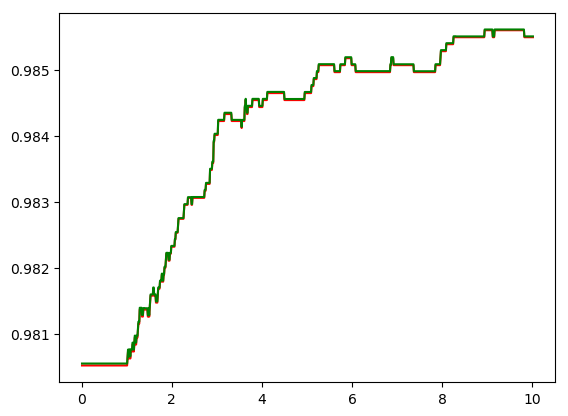

In [30]:
threshold_vs_accuraccy(test_history)